## 패키지 임포트

1. 필수 라이브러리

In [1]:
#import main libraries (numpy for data and matplotlib for plotting)
import numpy as np 
import matplotlib.pyplot as plt
import os

from tqdm import trange
import random

In [2]:
# User parameters

features=['A+IGBT-I', 'A+*IGBT-I', 'B+IGBT-I', 'B+*IGBT-I', 'C+IGBT-I', 'C+*IGBT-I', 'A-FLUX', 
          'B-FLUX', 'C-FLUX', 'MOD-V', 'MOD-I', 'CB-I', 'CB-V', 'DV/DT']  # waveform names to use as a header
feature_index=6  # A-flux waveform (for plotting). Use 0 for A+IGBT-I, 1 for A+*IGBT-I, and so on.
system='RFQ'     # pick a system to load and plot. Choose RFQ, DTL, CCL, or SCL

In [27]:
#load both waveform (X) and labels (Y) datasets for an HVCM module, e.g. RFQ, DTL, CCL, SCL
X= np.load('./hvcm/%s.npy'%system)   #---> X array has shape: (pulses, times, features)
Y=np.load('./hvcm/%s_labels.npy'%system, allow_pickle=True)  #---> Y array has shape: (pulses, labels) --> labels are: index, state, type
time=np.arange(X.shape[1]) * 400e-9    #create time axis based on the sampling rate 400 ns (for plotting purposes)

In [28]:
time

array([0.0000e+00, 4.0000e-07, 8.0000e-07, ..., 1.7988e-03, 1.7992e-03,
       1.7996e-03])

In [5]:
# to check the shape and elements of X,Y
print(X.shape) # 3D-X의 형태 (파형 데이터, 400ns의 샘플링 갯수(총 1.8ms), unique waveforms)
print(Y.shape) # 2D-Y의 형태 (파형데이터, (데이터 라벨, 정상/오류, 정상/오류의 종류))
print(X[1]) # 3D-X의 2번째 정상신호 샘플
print()
print(Y[1]) # 2D-Y의 2번째 정상신호 샘플
print()
print(X[690]) # 3D-X의 690번째 비정상신호 샘플
print()
print(Y[690]) # 2D-Y의 690번째 비정상신호 샘플

(872, 4500, 14)
(872, 3)
[[ 2.66730e-01  5.14970e+00  4.63120e+00 ...  1.50000e-02  2.18620e+03
  -1.76590e+01]
 [ 1.48750e+00  1.48750e+00  3.41040e+00 ... -4.60370e-02  2.18830e+03
  -1.76590e+01]
 [ 2.70820e+00  5.14970e+00  9.68960e-01 ...  1.06560e-01  2.18770e+03
  -1.27760e+01]
 ...
 [ 1.85780e+01  6.37040e+00  1.80590e+01 ... -4.60370e-02  2.09310e+03
  -3.01100e+00]
 [ 1.49160e+01  6.37040e+00  1.80590e+01 ...  1.50000e-02  2.09390e+03
  -5.45182e+00]
 [ 1.49160e+01  7.59120e+00  1.80590e+01 ...  4.55190e-02  2.09190e+03
   1.87300e+00]]

['./RFQ/RFQ_400ns_12_Hour_Run_3.12.2022-6.23.59AM.csv' 'Run' 'Normal']

[[-5.8370e+00 -3.3955e+00 -5.1347e+00 ... -4.6037e-02  2.2826e+03
  -1.7660e+01]
 [-7.0577e+00  1.4875e+00 -6.3555e+00 ... -1.0707e-01  2.2849e+03
  -1.2776e+01]
 [-5.8370e+00 -9.5401e-01 -3.9140e+00 ... -1.0707e-01  2.2865e+03
  -1.5218e+01]
 ...
 [-2.1747e+00 -4.6162e+00 -5.1347e+00 ...  1.5000e-02  2.2834e+03
  -5.4520e+00]
 [-4.6162e+00  2.6673e-01 -5.1347e+00 ...  1.

In [4]:
# Split X/Y arrays into fault and normal data

"""obtain array indices to split normal and fault data using the second column in Y """
fault_indices, normal_indices=np.where(Y[:,1] == 'Fault')[0], np.where(Y[:,1] == 'Run')[0]

In [121]:
a_flux_fault_indices = np.where(Y[:,2] == 'A FLUX Low Fault')

In [124]:
print((a_flux_fault_indices[0][0]))

701


In [5]:
#Use the indices to assign normal data to `Xnormal` and fault data to `Xanomaly` 
Xnormal, Xanomaly = X[normal_indices,:,:], X[fault_indices,:,:]

In [6]:
#Use the indices to assign the labels of normal data to `Ynormal` and fault labels to `Yanomaly` 
Ynormal, Yanomaly = Y[normal_indices,:], Y[fault_indices,:]   #labels are: index, state, type

In [133]:
a_flux_fault_indices = np.where(Yanomaly[:,2]== 'A FLUX Low Fault')[0]

In [134]:
a_flux_anomaly = X[a_flux_fault_indices,:,:]

In [135]:
Xanomaly.shape

(182, 4500, 14)

In [136]:
a_flux_anomaly.shape

(6, 4500, 14)

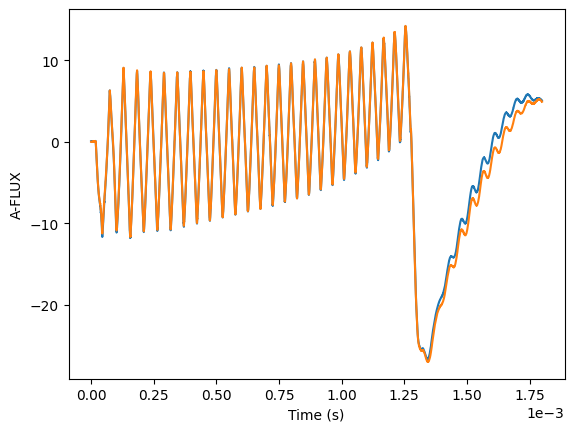

In [140]:
plt.figure()
plt.plot(time, a_flux_anomaly[0,:,feature_index])   #plot A-flux fault 1
plt.plot(time, a_flux_anomaly[1,:,feature_index])   #plot A-flux fault 2
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index])  #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

In [58]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

In [142]:
a_flux_anomaly_append = min_max_scaler.fit_transform(a_flux_anomaly[0,:,feature_index].reshape(-1,1))
for i in range(1,2):
    tmp = min_max_scaler.fit_transform(a_flux_anomaly[i,:,feature_index].reshape(-1,1))
    a_flux_anomaly_append = np.append(a_flux_anomaly_append, tmp)


In [77]:
tmp1 = min_max_scaler.fit_transform(Xanomaly[0,:,feature_index].reshape(-1,1))
tmp2 = min_max_scaler.fit_transform(Xanomaly[1,:,feature_index].reshape(-1,1))

In [78]:
Xanomaly_concat = np.concatenate(
    (tmp1,tmp2),
     axis=0)

In [79]:
(Xanomaly_concat.flatten()).size

9000

In [80]:
time_append =np.arange(Xanomaly_concat.size) * 400e-9

In [81]:
time_append.shape

(9000,)

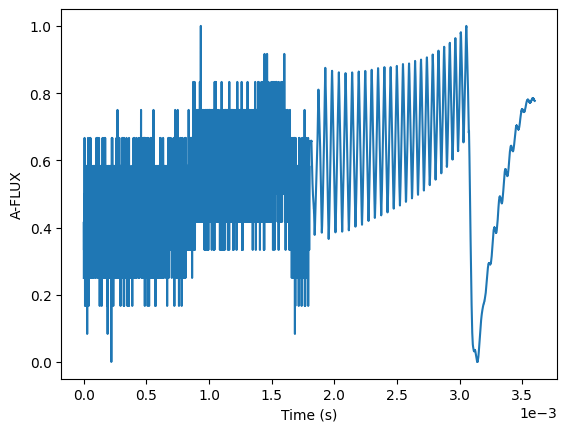

In [82]:
plt.figure()
plt.plot(time_append, Xanomaly_concat)   #plot A-flux normal
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index])  #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

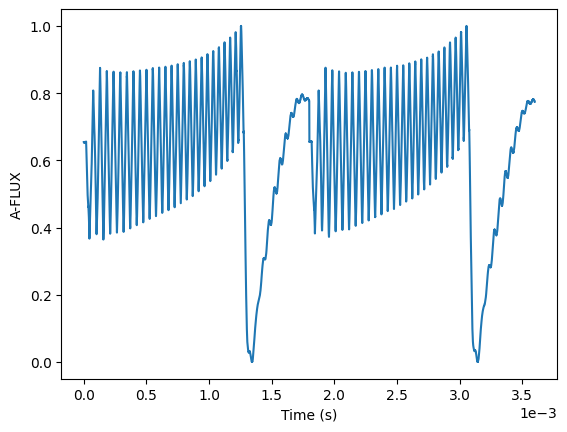

In [143]:
plt.figure()
plt.plot(time_append, a_flux_anomaly_append)   #plot A-flux normal
plt.xlabel('Time (s)')  #add x-label
plt.ylabel(features[feature_index])  #add y-label
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0)) #use sci notation
plt.show()  #show the plot

In [12]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
# for i in range(len(Xanomaly)):
#     Xanomaly[i,:,feature_index] = min_max_scaler.fit_transform(Xanomaly[i,:,feature_index].reshape(1, -1))

In [46]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda", index=0)

c:\Users\김기후\KimGihu\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
class lstm_encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)

    def forward(self, x_input):
        lstm_out, self.hidden = self.lstm(x_input)
        return lstm_out, self.hidden

In [54]:
class lstm_decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):
        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(-1), encoder_hidden_states)
        output = self.linear(lstm_out)

        return output, self.hidden

In [55]:
class lstm_encoder_decoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(lstm_encoder_decoder, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)

    def forward(self, inputs, targets, target_len, teacher_forcing_ratio):
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]

        outputs = torch.zeros(batch_size, target_len, input_size)

        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            if random.random() < teacher_forcing_ratio:
                decoder_input = targets[:, t, :]
            else:
                decoder_input = out
            outputs[:,t,:] = out

        return outputs

    def predict(self, inputs, target_len):
        inputs = inputs.unsqueeze(0)
        self.eval()
        batch_size = inputs.shape[0]
        input_size = inputs.shape[2]
        outputs = torch.zeros(batch_size, target_len, input_size)
        _, hidden = self.encoder(inputs)
        decoder_input = inputs[:,-1, :]
        for t in range(target_len): 
            out, hidden = self.decoder(decoder_input, hidden)
            out =  out.squeeze(1)
            decoder_input = out
            outputs[:,t,:] = out
        return outputs.detach().numpy()[0,:,0]

In [56]:
from torch.utils.data import DataLoader, Dataset

class windowDataset(Dataset):
    def __init__(self, y, input_window=80, output_window=20, stride=5):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples])

        for i in np.arange(num_samples):
            start_x = stride*i
            end_x = start_x + input_window
            X[:,i] = y[start_x:end_x]

            start_y = stride*i + input_window
            end_y = start_y + output_window
            Y[:,i] = y[start_y:end_y]

        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 1).transpose((1,0,2))
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [59]:
Xanomaly.shape

(182, 4500, 14)

In [60]:
iw = 24*14
ow = 24*7

train_dataset = windowDataset(Xanomaly[0,:,feature_index], input_window=iw, output_window=ow, stride=1)
train_loader = DataLoader(train_dataset, batch_size=64)

In [61]:
model = lstm_encoder_decoder(input_size=1, hidden_size=16).to(device)


In [62]:
learning_rate=0.01
epoch = 3000
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.MSELoss()

# 학습하기 이전

In [63]:
predict = model.predict(torch.tensor(train_dataset[0][0]).to(device).float(), target_len=ow)
real = train_dataset[0][1]

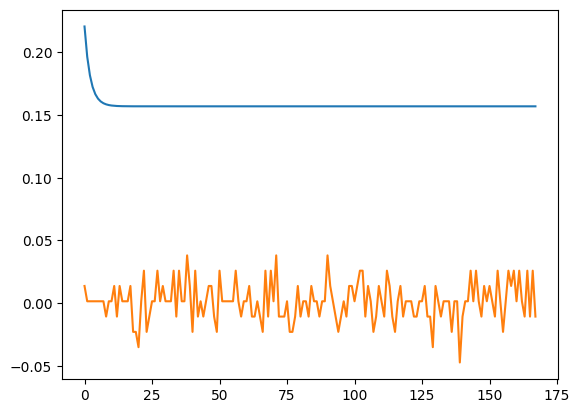

In [64]:
plt.plot(predict)
plt.plot(real)

In [65]:
from tqdm import tqdm

model.train()
with tqdm(range(epoch)) as tr:
    for i in tr:
        total_loss = 0.0
        for x,y in train_loader:
            optimizer.zero_grad()
            x = x.to(device).float()
            y = y.to(device).float()
            output = model(x, y, ow, 0.6).to(device)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.cpu().item()
        tr.set_postfix(loss="{0:.5f}".format(total_loss/len(train_loader)))

100%|██████████| 3000/3000 [9:30:54<00:00, 11.42s/it, loss=0.00039]  


In [66]:
torch.save(model.state_dict, './lstm_basic.h5')